# Synoptic Stations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Stations 

| Station Name | Code | Latitude | Longitude | Elevation (ft) |
|---------------|-------|-----------|------------|----------------|
| **SCE Sumac Ridge** | 826SE | 34.04457 | -118.64590 | 658.0 |
| **SCE Topanga Beach** | SE208 | 34.04040 | -118.58070 | 118.0 |
| **SCE Ridgemont Dr** | SE734 | 34.04092 | -118.67310 | 237.0 |


In [2]:
# Mapping the Stations
m = folium.Map(location=[34.0425, -118.633], zoom_start=12)
stations = [
    {
        "name": "SCE Sumac Ridge",
        "code": "826SE",
        "lat": 34.04457,
        "lon": -118.64590,
        "elevation": 658.0
    },
    {
        "name": "SCE Topanga Beach",
        "code": "SE208",
        "lat": 34.04040,
        "lon": -118.58070,
        "elevation": 118.0
    },
    {
        "name": "SCE Ridgemont Dr",
        "code": "SE734",
        "lat": 34.04092,
        "lon": -118.67310,
        "elevation": 237.0
    }
]

for s in stations:
    popup_html = (
        f"<b>{s['name']}</b><br>"
        f"Code: {s['code']}<br>"
        f"Lat: {s['lat']}<br>"
        f"Lon: {s['lon']}<br>"
        f"Elevation: {s['elevation']} ft"
    )
    folium.Marker(
        [s['lat'], s['lon']],
        popup=popup_html,
        tooltip=s['name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

m

## Exploratory Data Analysis

### Loading the dataframe

In [3]:
# Using 826SE as example
df = pd.read_csv("data/826SE.2025-01-31.csv", header=10, skiprows=[11])
df = df.rename(columns={
    "Date_Time": "datetime",
    "air_temp_set_1": "air_temp",
    "relative_humidity_set_1": "relative_humidity",
    "wind_speed_set_1": "wind_speed",
    "wind_direction_set_1": "wind_direction",
    "wind_gust_set_1": "wind_gust",
    "volt_set_1": "voltage",
    "wind_chill_set_1d": "wind_chill",
    "wind_cardinal_direction_set_1d": "wind_cardinal",
    "heat_index_set_1d": "heat_index",
    "dew_point_temperature_set_1d": "dew_point"
})
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
df.head()

,Station_ID,air_temp,relative_humidity,wind_speed,wind_direction,wind_gust,voltage,wind_chill,wind_cardinal,heat_index,dew_point
datetime,,,,,,,,,,,
2025-01-01 04:00:00-08:00,826SE,10.00,57.69,0.29,272.0,0.92,13.18,NaN,W,NaN,1.96
2025-01-01 04:10:00-08:00,826SE,11.30,54.09,0.50,260.5,1.18,13.18,NaN,W,NaN,2.27
2025-01-01 04:20:00-08:00,826SE,10.99,57.07,0.20,197.1,0.98,13.18,NaN,SSW,NaN,2.74
2025-01-01 04:30:00-08:00,826SE,10.16,60.14,0.02,142.7,0.29,13.18,NaN,SE,NaN,2.70
2025-01-01 04:40:00-08:00,826SE,9.84,61.81,0.02,142.5,0.52,13.18,NaN,SE,NaN,2.79


## Time Series - Key Thresholds

| Variable | Threshold | Operational Context |
|-----------|------------|---------------------|
| **Air Temp** | > 30 °C | Hot/dry fuels (NWS / CAL FIRE red-flag criterion) |
| **Relative Humidity** | < 20 % | Critically dry air/fuel (standard red-flag trigger) |
| **Wind Speed** | > 5 m/s | Moderate-strong winds promoting spread |

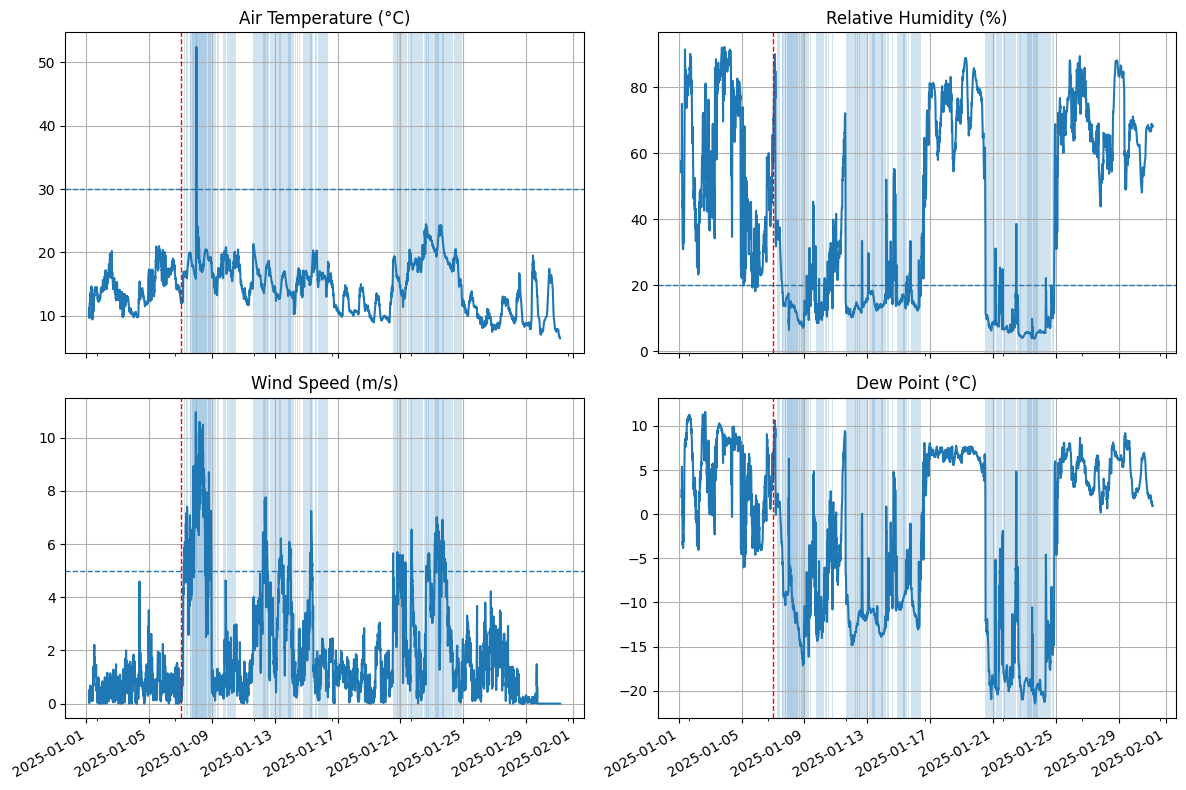

       Condition  Total Hours
        RH < 20%       260.83
    Temp > 30 °C         0.50
    Wind > 5 m/s        61.83
Any of the above       266.00


In [4]:
mask_rh  = df["relative_humidity"] < 20
mask_t   = df["air_temp"] > 30
mask_w   = df["wind_speed"] > 5

mask_any = mask_rh | mask_t | mask_w

def contiguous_spans(mask: pd.Series):
    """
    Return a list of (start_ts, end_ts) tuples for contiguous True regions in a boolean Series.
    """
    mask = mask.fillna(False)
    # Identify change points
    change = mask.ne(mask.shift(1)).cumsum()
    spans = []
    for _, grp in mask[mask].groupby(change):
        start = grp.index[0]
        end   = grp.index[-1]
        spans.append((start, end))
    return spans

spans_rh  = contiguous_spans(mask_rh)
spans_t   = contiguous_spans(mask_t)
spans_w   = contiguous_spans(mask_w)
spans_any = contiguous_spans(mask_any)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

df["air_temp"].plot(ax=axs[0, 0], title="Air Temperature (°C)")
df["relative_humidity"].plot(ax=axs[0, 1], title="Relative Humidity (%)")
df["wind_speed"].plot(ax=axs[1, 0], title="Wind Speed (m/s)")
df["dew_point"].plot(ax=axs[1, 1], title="Dew Point (°C)")
axs[0, 0].axhline(30, linestyle="--", linewidth=1)   # temp threshold
axs[0, 1].axhline(20, linestyle="--", linewidth=1)   # RH threshold
axs[1, 0].axhline(5,  linestyle="--", linewidth=1)   # wind threshold

# Helper to shade spans on all axes (use a light alpha)
def shade_spans(axs, spans, alpha=0.15):
    for (start, end) in spans:
        # Add a small epsilon to end so shading shows up for single timestamp rows
        end_eps = end if end > start else end + pd.Timedelta(minutes=1)
        for ax in np.ravel(axs):
            ax.axvspan(start, end_eps, alpha=alpha)

# Shade by each condition with different opacities (no explicit colors)
shade_spans(axs, spans_rh,  alpha=0.20)  # RH < 20%
shade_spans(axs, spans_t,   alpha=0.20)  # Temp > 30 C
shade_spans(axs, spans_w,   alpha=0.20)  # Wind > 5 m/s

event_time = pd.Timestamp("2025-01-07", tz=getattr(df.index, "tz", None))
for ax in axs.flat:
    ax.set_xlabel("")
    ax.axvline(event_time, color="red", linestyle="--", linewidth=1)
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Summary of exceedances (duration in hours) ---
def spans_duration_hours(spans):
    if not spans:
        return 0.0
    total = pd.Timedelta(0)
    for s, e in spans:
        # inclusive of endpoints; assume fixed sampling ~10 min; robustly compute delta
        total += (e - s)
    return total.total_seconds() / 3600.0

summary = pd.DataFrame({
    "Condition": ["RH < 20%", "Temp > 30 °C", "Wind > 5 m/s", "Any of the above"],
    "Total Hours": [
        round(spans_duration_hours(spans_rh), 2),
        round(spans_duration_hours(spans_t), 2),
        round(spans_duration_hours(spans_w), 2),
        round(spans_duration_hours(spans_any), 2),
    ]
})
print(summary.to_string(index=False))

## Daily Averages

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

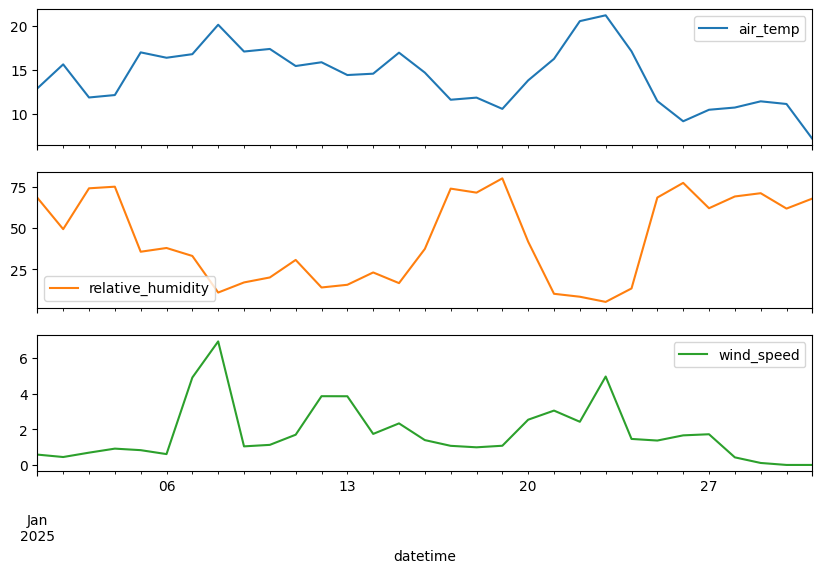

In [5]:
daily = df.resample("D").mean(numeric_only=True)
daily[["air_temp", "relative_humidity", "wind_speed"]].plot(subplots=True, figsize=(10,6))

## Relative Humidity vs Air Temperature

<Axes: title={'center': 'Temp vs Humidity'}, xlabel='air_temp', ylabel='relative_humidity'>

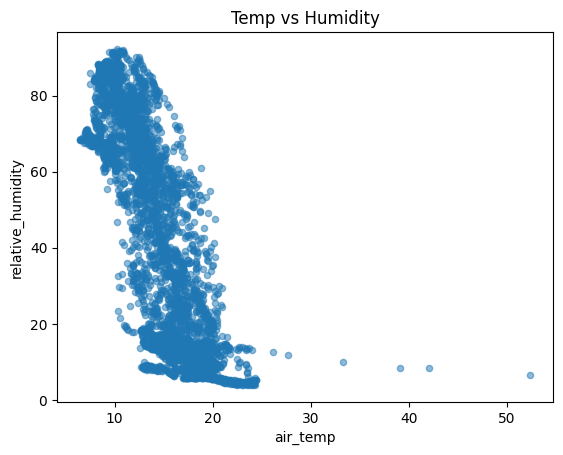

In [6]:
df.plot.scatter("air_temp", "relative_humidity", alpha=0.5, title="Temp vs Humidity")

## Wind Direction Distribution

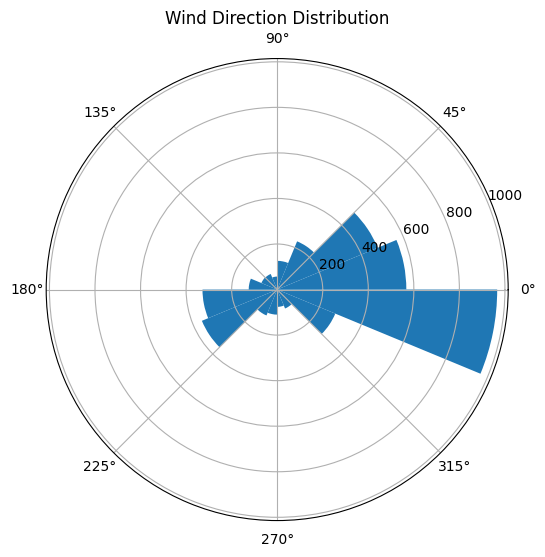

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(projection='polar')
plt.hist(np.deg2rad(df["wind_direction"].dropna()), bins=16)
plt.title("Wind Direction Distribution")
plt.show()

## Vapor Pressure Deficit and Dew Point Depression

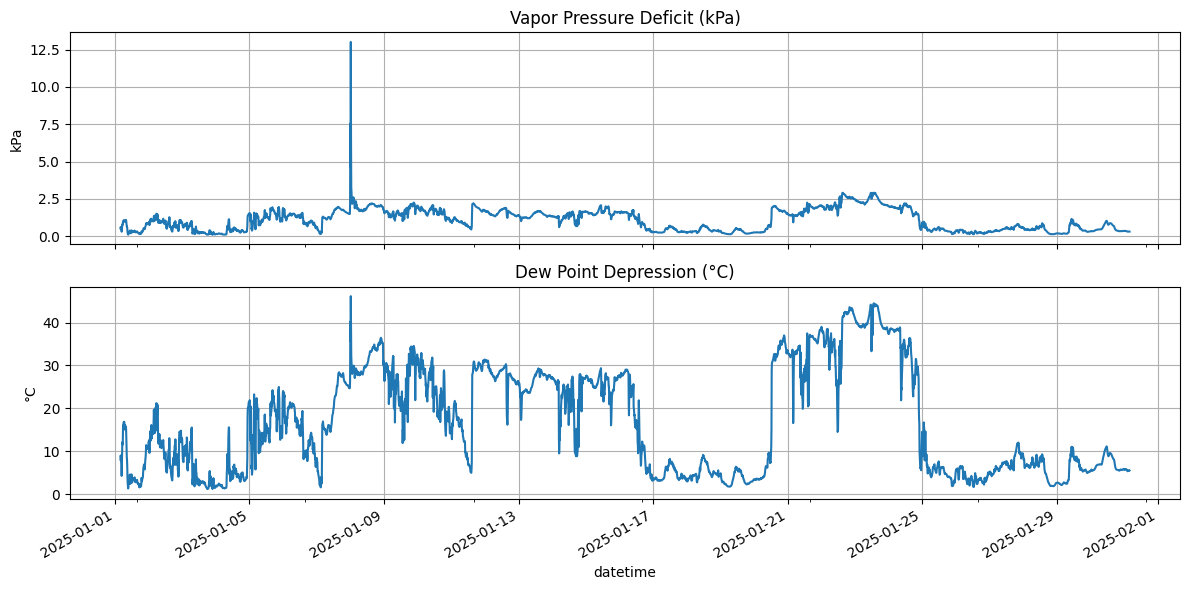

In [8]:
df["dpd"] = df["air_temp"] - df["dew_point"]

# --- VPD (kPa) using Magnus formula ---
# Saturation vapor pressure (es) in kPa
def es_kpa_celsius(t_c):
    # Tetens/Magnus: es (kPa) = 0.6108 * exp(17.27*T / (T + 237.3))
    return 0.6108 * np.exp((17.27 * t_c) / (t_c + 237.3))

# Actual vapor pressure ea from RH (%)
def ea_kpa_from_rh(t_c, rh_pct):
    return es_kpa_celsius(t_c) * (rh_pct / 100.0)

df["es_kpa"] = es_kpa_celsius(df["air_temp"])
df["ea_kpa"] = ea_kpa_from_rh(df["air_temp"], df["relative_humidity"])
df["vpd_kpa"] = (df["es_kpa"] - df["ea_kpa"]).clip(lower=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

df["vpd_kpa"].plot(ax=axes[0], title="Vapor Pressure Deficit (kPa)")
axes[0].set_ylabel("kPa")
axes[0].grid(True)

df["dpd"].plot(ax=axes[1], title="Dew Point Depression (°C)")
axes[1].set_ylabel("°C")
axes[1].grid(True)

plt.tight_layout()
plt.show()